# ConvFM Model Training Notebook

This notebook demonstrates how to train and use the ConvFM (Convolutional Factorization Machine) model for recommendation systems.


## 1. Import Required Libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cpu


## 2. Import ConvFM Model and Data Loader


In [2]:
# Import our custom modules
from convfm_model import ConvFM, ConvFMConfig
from data_loader import load_csv_data, create_sample_data, DataPreprocessor, RecommendationDataset

# Import improved model (if available)
try:
    from convfm_improved import ImprovedConvFM, ImprovedConvFMConfig, FocalLoss
    IMPROVED_MODEL_AVAILABLE = True
    print("✓ Improved model available")
except ImportError:
    IMPROVED_MODEL_AVAILABLE = False
    print("Using standard ConvFM model (improved version not available)")


✓ Improved model available


## 3. Load and Explore Data

Replace the file path with your own data file.


In [3]:
# Load your data
# Set your data path here
DATA_PATH = r"C:\Users\KIRAN\Downloads\confm-sheet2-sourcetable.csv"

# You can also manually specify feature columns and target if needed:
# FEATURE_COLUMNS = ['user_id', 'job_id', 'user_education', 'job_type', 'location']
# TARGET_COLUMN = 'label'

# Note: The next cell will auto-detect columns if not specified above
print(f"✓ Data path configured: {DATA_PATH}")
print("Feature columns and target will be auto-detected in Cell 7")


✓ Data path configured: C:\Users\KIRAN\Downloads\confm-sheet2-sourcetable.csv
Feature columns and target will be auto-detected in Cell 7


In [4]:
# Load and explore the data
try:
    # Use DATA_PATH from cell 6
    if 'DATA_PATH' not in globals():
        # If DATA_PATH wasn't set, use the specified path
        DATA_PATH = r"C:\Users\KIRAN\Downloads\confm-sheet2-sourcetable.csv"
    
    data_path = DATA_PATH
    print(f"Loading data from: {data_path}")
    
    df = pd.read_csv(data_path)
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head())
    
    # Auto-detect feature columns and target column
    # Exclude text columns and the target column
    text_columns = ['user_text', 'job_text', 'user_skills', 'job_skills']
    
    # Get all columns except text columns
    potential_features = [col for col in df.columns if col not in text_columns]
    
    # Try to detect target column (common names: label, target, rating, score, y)
    target_candidates = ['label', 'target', 'rating', 'score', 'y']
    TARGET_COLUMN = None
    for candidate in target_candidates:
        if candidate in df.columns:
            TARGET_COLUMN = candidate
            break
    
    if TARGET_COLUMN is None:
        # If no standard target found, assume last column is target
        TARGET_COLUMN = df.columns[-1]
        print(f"\nWarning: Could not auto-detect target. Using last column: {TARGET_COLUMN}")
    
    # Remove target from feature columns
    FEATURE_COLUMNS = [col for col in potential_features if col != TARGET_COLUMN]
    
    # Update DATA_PATH for use in later cells
    DATA_PATH = data_path
    
    print(f"\n{'='*60}")
    print("Auto-detected Configuration:")
    print(f"{'='*60}")
    print(f"  Feature columns: {FEATURE_COLUMNS}")
    print(f"  Target column: {TARGET_COLUMN}")
    print(f"  Number of features: {len(FEATURE_COLUMNS)}")
    print(f"{'='*60}")
    
except FileNotFoundError as e:
    print(f"Error: File not found: {e}")
    print("\nPlease check the file path in Cell 6 or update DATA_PATH variable.")
    print("Alternatively, create sample data by running:")
    print("  sample_data = create_sample_data(n_samples=10000, n_fields=4)")
except Exception as e:
    print(f"Error loading data: {e}")
    print("\nTrying to create sample data for demonstration...")
    try:
        sample_data = create_sample_data(
            n_samples=10000,
            n_fields=4,
            save_path='sample_recommendation_data.csv'
        )
        df = pd.read_csv('sample_recommendation_data.csv')
        DATA_PATH = 'sample_recommendation_data.csv'
        FEATURE_COLUMNS = ['field_1', 'field_2', 'field_3', 'field_4']
        TARGET_COLUMN = 'rating'
        print(f"\nUsing sample data:")
        print(f"  Feature columns: {FEATURE_COLUMNS}")
        print(f"  Target column: {TARGET_COLUMN}")
        display(df.head())
    except Exception as e2:
        print(f"Could not create sample data: {e2}")
        raise


Loading data from: C:\Users\KIRAN\Downloads\confm-sheet2-sourcetable.csv
Dataset shape: (1000, 10)

Columns: ['user_id', 'job_id', 'user_text', 'job_text', 'user_skills', 'job_skills', 'user_education', 'job_type', 'location', 'label']

First few rows:


,user_id,job_id,user_text,job_text,user_skills,job_skills,user_education,job_type,location,label
0,U0001,J0328,Skilled UX Designer with expertise in Node.js ...,Hiring Cloud Solutions Architect with strong R...,"SQL, C++, Spring Boot, Elasticsearch, Spark, F...","Git, Machine Learning, Problem Solving",B.Tech in Computer Science,Contract,"Gurgaon, Haryana",0
1,U0002,J0391,Experienced Content Writer with 7 years in Clo...,Leading Fintech company seeking talented Data ...,"Data Warehousing, Azure, Creativity, Flask, HT...","Swift, Cybersecurity, Critical Thinking, Git, ...",M.Tech in Data Science,Part-time,"Ahmedabad, Gujarat",0
2,U0003,J0350,11 years as Backend Developer. Specialized in ...,Hiring Product Manager with strong Git skills....,"Kafka, Communication, Vue.js, Spark, SQL, Grap...","PyTorch, React Native, TensorFlow, REST API, D...",M.Tech in Data Science,Internship,"Indore, Madhya Pradesh",0
3,U0004,J0205,Graphic Designer from MBA seeking opportunitie...,We are looking for React Developer to join our...,"Node.js, Attention to Detail, Creativity, Agil...","Git, Cybersecurity, Python, React Native, Fina...",MBA,Hybrid,"Mumbai, Maharashtra",0
4,U0005,J0153,4 years as Backend Developer. Specialized in C...,Hiring Junior Data Scientist with strong React...,"SEO, JavaScript, AWS, Critical Thinking, TypeS...","GCP, Scrum, E-commerce, Jenkins",B.Sc in Computer Science,Contract,"Bhubaneswar, Odisha",0



Auto-detected Configuration:
  Feature columns: ['user_id', 'job_id', 'user_education', 'job_type', 'location']
  Target column: label
  Number of features: 5


In [5]:
# Data statistics
# Check if df and TARGET_COLUMN are defined
if 'df' not in globals():
    print("Error: df (dataframe) is not defined.")
    print("Please run Cell 7 first to load the data.")
    raise NameError("df must be defined. Run Cell 7 first.")

if 'TARGET_COLUMN' not in globals():
    print("Error: TARGET_COLUMN is not defined.")
    print("Please run Cell 7 first to auto-detect the target column.")
    raise NameError("TARGET_COLUMN must be defined. Run Cell 7 first.")

print("Dataset Info:")
print(df.info())
print("\n" + "="*60)
print("Descriptive Statistics:")
print(df.describe())

# Check target column type and distribution
print(f"\n{'='*60}")
print(f"Target Column Analysis: {TARGET_COLUMN}")
print(f"{'='*60}")
print(f"Unique values: {df[TARGET_COLUMN].unique()}")
print(f"Value counts:\n{df[TARGET_COLUMN].value_counts()}")
print(f"Data type: {df[TARGET_COLUMN].dtype}")

# Determine if it's classification or regression
is_binary_classification = (df[TARGET_COLUMN].dtype in ['int64', 'int32', 'bool'] and 
                           df[TARGET_COLUMN].nunique() == 2 and
                           set(df[TARGET_COLUMN].unique()).issubset({0, 1}))
print(f"Is binary classification: {is_binary_classification}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         1000 non-null   object
 1   job_id          1000 non-null   object
 2   user_text       1000 non-null   object
 3   job_text        1000 non-null   object
 4   user_skills     1000 non-null   object
 5   job_skills      1000 non-null   object
 6   user_education  1000 non-null   object
 7   job_type        1000 non-null   object
 8   location        1000 non-null   object
 9   label           1000 non-null   int64 
dtypes: int64(1), object(9)
memory usage: 78.3+ KB
None

Descriptive Statistics:
             label
count  1000.000000
mean      0.088000
std       0.283437
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

Target Column Analysis: label
Unique values: [0 1]
Value counts:
label
0    912
1     88
Name: coun

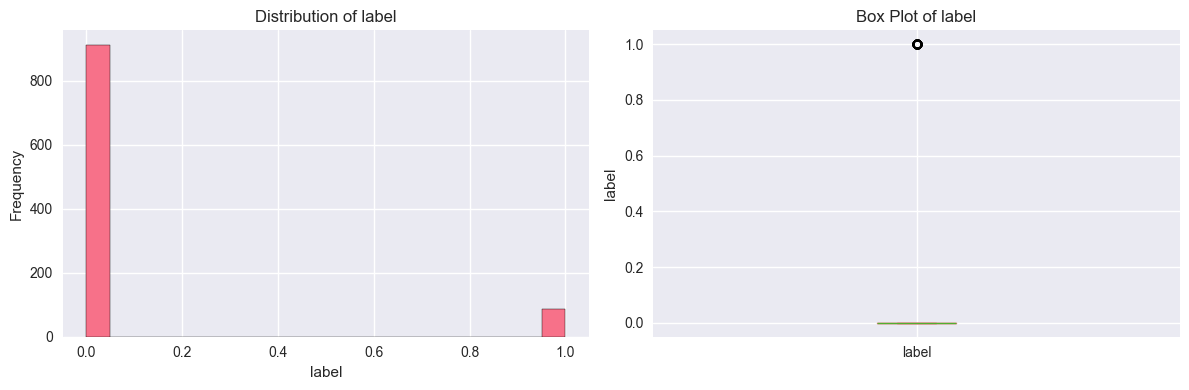

In [6]:
# Visualize target distribution
# Check if required variables are defined
if 'df' not in globals():
    print("Error: df (dataframe) is not defined.")
    print("Please run Cell 7 first to load the data.")
    raise NameError("df must be defined. Run Cell 7 first.")

if 'TARGET_COLUMN' not in globals():
    print("Error: TARGET_COLUMN is not defined.")
    print("Please run Cell 7 first to auto-detect the target column.")
    raise NameError("TARGET_COLUMN must be defined. Run Cell 7 first.")

# Check if TARGET_COLUMN exists in dataframe
if TARGET_COLUMN not in df.columns:
    print(f"Error: Column '{TARGET_COLUMN}' not found in the dataframe.")
    print(f"Available columns: {list(df.columns)}")
    raise ValueError(f"TARGET_COLUMN '{TARGET_COLUMN}' not found in dataframe.")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df[TARGET_COLUMN].hist(bins=20, edgecolor='black')
plt.title(f'Distribution of {TARGET_COLUMN}')
plt.xlabel(TARGET_COLUMN)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df[TARGET_COLUMN].plot(kind='box')
plt.title(f'Box Plot of {TARGET_COLUMN}')
plt.ylabel(TARGET_COLUMN)

plt.tight_layout()
plt.show()


In [7]:
# Load and preprocess data
# This cell will split the data into training (80%) and validation (20%) sets
try:
    # Check if variables are defined from previous cell
    if 'FEATURE_COLUMNS' not in globals() or 'TARGET_COLUMN' not in globals():
        print("Error: FEATURE_COLUMNS and TARGET_COLUMN are not defined.")
        print("Please run Cell 7 first to load and analyze the data.")
        print("\nIf you want to manually set them, uncomment and modify:")
        print("  FEATURE_COLUMNS = ['user_id', 'job_id', 'user_education', 'job_type', 'location']")
        print("  TARGET_COLUMN = 'label'")
        raise NameError("FEATURE_COLUMNS and TARGET_COLUMN must be defined. Run Cell 7 first.")
    
    if 'DATA_PATH' not in globals():
        print("Error: DATA_PATH is not defined.")
        print("Please run Cell 6 or Cell 7 first.")
        raise NameError("DATA_PATH must be defined.")
    
    print(f"Using configuration:")
    print(f"  Data path: {DATA_PATH}")
    print(f"  Feature columns: {FEATURE_COLUMNS}")
    print(f"  Target column: {TARGET_COLUMN}")
    print(f"\n{'='*60}")
    print("Data Split Configuration:")
    print(f"{'='*60}")
    print(f"  Training set: 80% (used to train the model)")
    print(f"  Validation set: 20% (used for evaluation and early stopping)")
    print(f"  Random state: 42 (for reproducibility)")
    print(f"  Split method: sklearn.train_test_split")
    print(f"{'='*60}\n")
    
    # Split data into train and validation sets
    train_loader, val_loader, preprocessor, field_dims = load_csv_data(
        file_path=DATA_PATH,
        feature_columns=FEATURE_COLUMNS,
        target_column=TARGET_COLUMN,
        test_size=0.2,  # 20% for validation, 80% for training
        random_state=42  # For reproducible splits
    )
    
    print(f"\n{'='*60}")
    print("Data Preprocessing Complete")
    print(f"{'='*60}")
    print(f"Field dimensions: {field_dims}")
    print(f"Total number of fields: {len(field_dims)}")
    print(f"Total embedding parameters: {sum(field_dims) * 16}")  # Assuming embed_dim=16
    
    # Verify data shapes
    print(f"\nData verification:")
    sample_batch = next(iter(train_loader))
    print(f"  Batch features shape: {sample_batch[0].shape}")
    print(f"  Batch labels shape: {sample_batch[1].shape}")
    print(f"  Label range: [{sample_batch[1].min():.2f}, {sample_batch[1].max():.2f}]")
    print(f"{'='*60}\n")
    
except NameError as e:
    print(f"\n{'='*60}")
    print("Variable Definition Error")
    print(f"{'='*60}")
    print(str(e))
    print("\nSolution: Please run the cells in order:")
    print("  1. Cell 6: Set DATA_PATH")
    print("  2. Cell 7: Load data and auto-detect columns")
    print("  3. Cell 11: Preprocess data (this cell)")
    print(f"{'='*60}\n")
    raise
except FileNotFoundError as e:
    print(f"\n{'='*60}")
    print("File Not Found Error")
    print(f"{'='*60}")
    print(f"Could not find file: {DATA_PATH if 'DATA_PATH' in globals() else 'N/A'}")
    print("\nPlease check:")
    print("  1. The file path in Cell 6 is correct")
    print("  2. The file exists at the specified location")
    print(f"{'='*60}\n")
    raise
except Exception as e:
    print(f"\n{'='*60}")
    print("Data Loading Error")
    print(f"{'='*60}")
    print(f"Error: {e}")
    print("\nPlease check:")
    print("  1. DATA_PATH points to a valid CSV file")
    print("  2. FEATURE_COLUMNS contains valid column names from your CSV")
    print("  3. TARGET_COLUMN exists in your CSV")
    print("  4. All columns in FEATURE_COLUMNS exist in the CSV file")
    print(f"{'='*60}\n")
    raise


Using configuration:
  Data path: C:\Users\KIRAN\Downloads\confm-sheet2-sourcetable.csv
  Feature columns: ['user_id', 'job_id', 'user_education', 'job_type', 'location']
  Target column: label

Data Split Configuration:
  Training set: 80% (used to train the model)
  Validation set: 20% (used for evaluation and early stopping)
  Random state: 42 (for reproducibility)
  Split method: sklearn.train_test_split

Loading data from C:\Users\KIRAN\Downloads\confm-sheet2-sourcetable.csv...
Total samples: 1000
Train samples: 800, Validation samples: 200
Field dimensions: [800, 406, 14, 6, 18]
Number of fields: 5

Data Preprocessing Complete
Field dimensions: [800, 406, 14, 6, 18]
Total number of fields: 5
Total embedding parameters: 19904

Data verification:
  Batch features shape: torch.Size([256, 5])
  Batch labels shape: torch.Size([256])
  Label range: [0.00, 1.00]



## 5. Initialize Model

In [10]:
# Model configuration
# Check if field_dims is defined from previous cell
if 'field_dims' not in globals():
    print("Error: field_dims is not defined.")
    print("Please run Cell 11 first to preprocess the data.")
    raise NameError("field_dims must be defined. Run Cell 11 first.")

# Choose model type: 'standard' or 'improved'
USE_IMPROVED_MODEL = True and IMPROVED_MODEL_AVAILABLE

if USE_IMPROVED_MODEL:
    print("Using IMPROVED ConvFM model with enhanced architecture")
    config = ImprovedConvFMConfig(
        embed_dim=32,           # Larger embedding dimension
        num_filters=128,        # More filters
        filter_sizes=[2, 3, 4],
        dropout=0.5,
        embed_dropout=0.1,      # Embedding dropout
        use_bn=True,
        use_layer_norm=False,
        hidden_dims=[128, 64],  # Deep hidden layers
        use_residual=True,      # Residual connections
        pool_type='both',       # Both max and avg pooling
        learning_rate=0.001,
        batch_size=256,
        num_epochs=50,
        early_stopping_patience=10,
        use_focal_loss=True,    # Use focal loss for imbalance
        focal_alpha=1.0,
        focal_gamma=2.0,
        weight_decay=1e-5,      # L2 regularization
        gradient_clip_val=1.0
    )
    
    model = ImprovedConvFM(
        field_dims=field_dims,
        embed_dim=config.embed_dim,
        num_filters=config.num_filters,
        filter_sizes=config.filter_sizes,
        dropout=config.dropout,
        embed_dropout=config.embed_dropout,
        use_bn=config.use_bn,
        hidden_dims=config.hidden_dims,
        use_residual=config.use_residual,
        pool_type=config.pool_type
    ).to(device)
else:
    print("Using STANDARD ConvFM model")
    config = ConvFMConfig(
        embed_dim=16,          # Embedding dimension
        num_filters=64,        # Number of convolutional filters
        filter_sizes=[2, 3, 4],
        dropout=0.5,
        use_bn=True,
        learning_rate=0.001,
        batch_size=256,
        num_epochs=50,
        early_stopping_patience=10
    )
    
    model = ConvFM(
        field_dims=field_dims,
        embed_dim=config.embed_dim,
        num_filters=config.num_filters,
        filter_sizes=config.filter_sizes,
        dropout=config.dropout,
        use_bn=config.use_bn
    ).to(device)

# Print model architecture
print(f"\n{'='*60}")
print("Model Initialized")
print(f"{'='*60}")
print(f"Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"{'='*60}\n")


Using IMPROVED ConvFM model with enhanced architecture

Model Initialized
Model Architecture:
ImprovedConvFM(
  (embeddings): ModuleList(
    (0): Embedding(800, 32)
    (1): Embedding(406, 32)
    (2): Embedding(14, 32)
    (3): Embedding(6, 32)
    (4): Embedding(18, 32)
  )
  (embed_dropout): Dropout(p=0.1, inplace=False)
  (linear): ModuleList(
    (0): Embedding(800, 1)
    (1): Embedding(406, 1)
    (2): Embedding(14, 1)
    (3): Embedding(6, 1)
    (4): Embedding(18, 1)
  )
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0): Conv1d(32, 128, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(32, 128, kernel_size=(4,), stride=(1,), padding=(2,))
  )
  (max_pool): AdaptiveMaxPool1d(output_size=1)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (hidden_layers): Sequential(
    (0): Linear(in_features=769, out_features=128, bias=True)
  

## 6. Training Setup

In [12]:
# Loss function and optimizer
# Check if train_loader is defined
if 'train_loader' not in globals():
    print("Error: train_loader is not defined.")
    print("Please run Cell 11 first to preprocess the data.")
    raise NameError("train_loader must be defined. Run Cell 11 first.")

# Check if model is defined
if 'model' not in globals():
    print("Error: model is not defined.")
    print("Please run Cell 13 first to initialize the model.")
    raise NameError("model must be defined. Run Cell 13 first.")

# Determine if binary classification based on target values
sample_batch = next(iter(train_loader))
label_sample = sample_batch[1]
is_binary = (label_sample.min() == 0 and label_sample.max() == 1 and 
             label_sample.dtype == torch.float32 and
             torch.all((label_sample == 0) | (label_sample == 1)))

if is_binary:
    # Calculate class weights to handle class imbalance
    # Count samples for each class in training set
    all_train_labels = []
    for batch_features, batch_labels in train_loader:
        all_train_labels.extend(batch_labels.numpy())
    all_train_labels = np.array(all_train_labels)
    
    class_counts = np.bincount(all_train_labels.astype(int))
    total_samples = len(all_train_labels)
    
    # Calculate class weights (inverse frequency)
    # Weight = total_samples / (num_classes * class_count)
    class_weights = total_samples / (len(class_counts) * class_counts)
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    print("Task Type: Binary Classification")
    print(f"Class distribution in training set:")
    print(f"  Class 0: {class_counts[0]} samples ({class_counts[0]/total_samples*100:.2f}%)")
    print(f"  Class 1: {class_counts[1]} samples ({class_counts[1]/total_samples*100:.2f}%)")
    print(f"\nClass weights (to handle imbalance):")
    print(f"  Class 0 weight: {class_weights[0]:.4f}")
    print(f"  Class 1 weight: {class_weights[1]:.4f}")
    
    # Choose loss function based on model type
    if USE_IMPROVED_MODEL and config.use_focal_loss:
        # Use Focal Loss for better handling of class imbalance
        criterion = FocalLoss(alpha=config.focal_alpha, gamma=config.focal_gamma)
        print(f"\nUsing Focal Loss (alpha={config.focal_alpha}, gamma={config.focal_gamma})")
        print("Focal loss focuses on hard examples and handles class imbalance naturally.")
    else:
        # Use weighted BCE loss to handle class imbalance
        pos_weight = class_weights[1] / class_weights[0]  # Weight for positive class
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        print(f"\nUsing WeightedBCEWithLogitsLoss (pos_weight={pos_weight:.4f})")
        print("This will penalize misclassifying the minority class more heavily.")
else:
    criterion = nn.MSELoss()  # For regression tasks
    print("Task Type: Regression")
    print("Using MSELoss for regression")

# Optimizer with weight decay for regularization
if USE_IMPROVED_MODEL and hasattr(config, 'weight_decay'):
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, 
                          weight_decay=config.weight_decay)
    print(f"Using Adam optimizer with weight decay: {config.weight_decay}")
else:
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    print("Using Adam optimizer")

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Gradient clipping value
gradient_clip_val = config.gradient_clip_val if (USE_IMPROVED_MODEL and hasattr(config, 'gradient_clip_val')) else None
if gradient_clip_val:
    print(f"Gradient clipping enabled: {gradient_clip_val}")

print(f"\nTraining Configuration:")
print(f"  Loss function: {criterion}")
print(f"  Optimizer: {optimizer}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Learning rate scheduler: ReduceLROnPlateau")
print()


Task Type: Binary Classification
Class distribution in training set:
  Class 0: 729 samples (91.12%)
  Class 1: 71 samples (8.88%)

Class weights (to handle imbalance):
  Class 0 weight: 0.5487
  Class 1 weight: 5.6338

Using Focal Loss (alpha=1.0, gamma=2.0)
Focal loss focuses on hard examples and handles class imbalance naturally.
Using Adam optimizer with weight decay: 1e-05
Gradient clipping enabled: 1.0

Training Configuration:
  Loss function: FocalLoss()
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
  Learning rate: 0.001
  Learning rate scheduler: ReduceLROnPlateau



## 7. Training Functions

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device, is_binary=False, 
                gradient_clip_val=None):
    """Train for one epoch with optional gradient clipping"""
    model.train()
    total_loss = 0
    total_samples = 0
    
    for features, labels in tqdm(train_loader, desc="Training"):
        features = features.to(device)
        labels = labels.to(device).float()
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(features)
        
        # For binary classification, squeeze predictions to match labels shape
        if is_binary:
            predictions = predictions.squeeze() if len(predictions.shape) > 1 and predictions.shape[1] == 1 else predictions
            
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (if enabled)
        if gradient_clip_val is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
        
        optimizer.step()
        
        total_loss += loss.item() * len(labels)
        total_samples += len(labels)
    
    avg_loss = total_loss / total_samples
    return avg_loss


def evaluate(model, val_loader, criterion, device, is_binary=False):
    """Evaluate on validation set"""
    model.eval()
    total_loss = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc="Evaluating"):
            features = features.to(device)
            labels = labels.to(device).float()
            
            predictions = model(features)
            
            # For binary classification, squeeze predictions and apply sigmoid
            if is_binary:
                predictions = predictions.squeeze() if len(predictions.shape) > 1 and predictions.shape[1] == 1 else predictions
                pred_probs = torch.sigmoid(predictions).cpu().numpy()
                all_predictions.extend(pred_probs)
            else:
                all_predictions.extend(predictions.cpu().numpy())
            
            loss = criterion(predictions, labels)
            
            total_loss += loss.item() * len(labels)
            total_samples += len(labels)
            
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / total_samples
    return avg_loss, np.array(all_predictions), np.array(all_labels)


## 8. Train the Model


In [14]:
# Training loop
# Check required variables
if 'train_loader' not in globals() or 'val_loader' not in globals():
    print("Error: train_loader or val_loader is not defined.")
    print("Please run Cell 11 first to preprocess the data.")
    raise NameError("Data loaders must be defined. Run Cell 11 first.")

if 'model' not in globals():
    print("Error: model is not defined.")
    print("Please run Cell 13 first to initialize the model.")
    raise NameError("model must be defined. Run Cell 13 first.")

if 'criterion' not in globals() or 'optimizer' not in globals():
    print("Error: criterion or optimizer is not defined.")
    print("Please run Cell 15 first to set up training configuration.")
    raise NameError("Training configuration must be set up. Run Cell 15 first.")

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

# Determine if binary classification (reuse from Cell 15 if available)
if 'is_binary' not in globals():
    sample_batch = next(iter(train_loader))
    label_sample = sample_batch[1]
    is_binary = (label_sample.min() == 0 and label_sample.max() == 1 and 
                 label_sample.dtype == torch.float32 and
                 torch.all((label_sample == 0) | (label_sample == 1)))
else:
    print(f"Using is_binary from previous cell: {is_binary}")

print(f"\n{'='*60}")
print("Starting Training")
print(f"Task type: {'Binary Classification' if is_binary else 'Regression'}")
print(f"{'='*60}\n")

for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch + 1}/{config.num_epochs}")
    print("-" * 60)
    
    # Train (with gradient clipping if enabled)
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, is_binary,
                            gradient_clip_val=gradient_clip_val if 'gradient_clip_val' in globals() else None)
    train_losses.append(train_loss)
    
    # Validate
    val_loss, val_predictions, val_labels = evaluate(model, val_loader, criterion, device, is_binary)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Print training progress
    if new_lr < current_lr:
        print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR reduced: {current_lr:.6f} → {new_lr:.6f}")
    else:
        print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6f}")
    
    # Early stopping and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"✓ New best model! (Val Loss: {val_loss:.6f})")
    else:
        patience_counter += 1
        if patience_counter >= config.early_stopping_patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"\n{'='*60}")
print("Training Completed!")
print(f"Best Validation Loss: {best_val_loss:.6f}")
print(f"{'='*60}")


Using is_binary from previous cell: True

Starting Training
Task type: Binary Classification


Epoch 1/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


Train Loss: 0.394255 | Val Loss: 0.116434 | LR: 0.001000
✓ New best model! (Val Loss: 0.116434)

Epoch 2/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 147.12it/s]


Train Loss: 0.165894 | Val Loss: 0.091768 | LR: 0.001000
✓ New best model! (Val Loss: 0.091768)

Epoch 3/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 78.03it/s]


Train Loss: 0.130570 | Val Loss: 0.081115 | LR: 0.001000
✓ New best model! (Val Loss: 0.081115)

Epoch 4/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.40it/s]


Train Loss: 0.107508 | Val Loss: 0.079548 | LR: 0.001000
✓ New best model! (Val Loss: 0.079548)

Epoch 5/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 63.18it/s]


Train Loss: 0.098378 | Val Loss: 0.079804 | LR: 0.001000

Epoch 6/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 133.40it/s]


Train Loss: 0.096891 | Val Loss: 0.078759 | LR: 0.001000
✓ New best model! (Val Loss: 0.078759)

Epoch 7/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 74.44it/s]


Train Loss: 0.096408 | Val Loss: 0.079813 | LR: 0.001000

Epoch 8/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.39it/s]


Train Loss: 0.085586 | Val Loss: 0.079425 | LR: 0.001000

Epoch 9/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 87.67it/s]


Train Loss: 0.082980 | Val Loss: 0.080461 | LR: 0.001000

Epoch 10/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 143.55it/s]


Train Loss: 0.072792 | Val Loss: 0.079830 | LR: 0.001000

Epoch 11/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 109.12it/s]


Train Loss: 0.080594 | Val Loss: 0.080633 | LR: 0.001000

Epoch 12/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 95.23it/s]


Train Loss: 0.074882 | Val Loss: 0.080419 | LR reduced: 0.001000 → 0.000500

Epoch 13/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 65.36it/s]


Train Loss: 0.068871 | Val Loss: 0.080785 | LR: 0.000500

Epoch 14/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 100.81it/s]


Train Loss: 0.075533 | Val Loss: 0.081151 | LR: 0.000500

Epoch 15/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 106.75it/s]


Train Loss: 0.066129 | Val Loss: 0.081717 | LR: 0.000500

Epoch 16/50
------------------------------------------------------------


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 114.40it/s]

Train Loss: 0.067351 | Val Loss: 0.082809 | LR: 0.000500

Early stopping triggered after 16 epochs

Training Completed!
Best Validation Loss: 0.078759


## 9. Visualize Training Progress


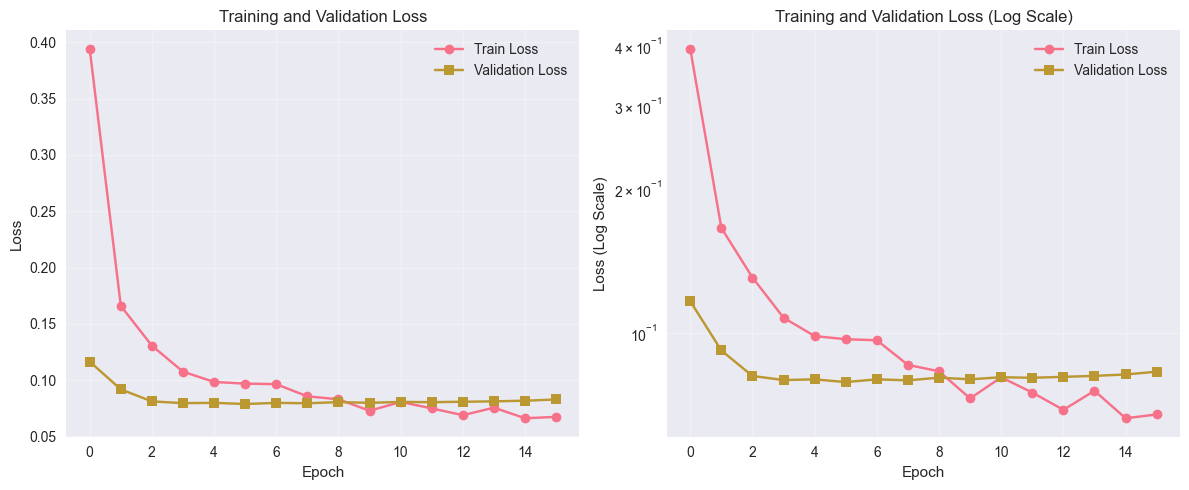

In [15]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.title('Training and Validation Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Evaluate Model Performance


In [16]:
# Final evaluation
# Check required variables
if 'val_loader' not in globals():
    print("Error: val_loader is not defined.")
    print("Please run Cell 11 first to preprocess the data.")
    raise NameError("val_loader must be defined. Run Cell 11 first.")

if 'model' not in globals() or 'criterion' not in globals():
    print("Error: model or criterion is not defined.")
    print("Please run cells 13 and 15 first.")
    raise NameError("Model and criterion must be defined.")

if 'is_binary' not in globals():
    print("Warning: is_binary not defined. Auto-detecting from data...")
    sample_batch = next(iter(val_loader))
    label_sample = sample_batch[1]
    is_binary = (label_sample.min() == 0 and label_sample.max() == 1 and 
                 label_sample.dtype == torch.float32 and
                 torch.all((label_sample == 0) | (label_sample == 1)))

val_loss, val_predictions, val_labels = evaluate(model, val_loader, criterion, device, is_binary)

# For imbalanced datasets, try different thresholds
if is_binary:
    print(f"\n{'='*60}")
    print("Class Imbalance Analysis")
    print(f"{'='*60}")
    
    # Find optimal threshold using F1 score
    from sklearn.metrics import f1_score
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in thresholds:
        pred_binary = (val_predictions > threshold).astype(int)
        f1 = f1_score(val_labels, pred_binary, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    print(f"Default threshold (0.5) F1 score: {f1_score(val_labels, (val_predictions > 0.5).astype(int), zero_division=0):.4f}")
    print(f"Optimal threshold: {best_threshold:.3f} (F1 score: {best_f1:.4f})")
    print(f"\nRecommendation: Use threshold = {best_threshold:.3f} for better minority class detection")
    print(f"{'='*60}\n")
    
    # Use optimal threshold for evaluation
    optimal_threshold = best_threshold

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

print(f"\n{'='*60}")
print("Model Evaluation Metrics")
print(f"{'='*60}")

if is_binary:
    # Binary classification metrics - try both default and optimal thresholds
    if 'optimal_threshold' in locals():
        print(f"Using optimal threshold: {optimal_threshold:.3f}")
        val_pred_binary = (val_predictions > optimal_threshold).astype(int)
    else:
        # Try to find optimal threshold
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_threshold = 0.5
        best_f1 = 0
        for threshold in thresholds:
            pred_temp = (val_predictions > threshold).astype(int)
            f1_temp = f1_score(val_labels, pred_temp, zero_division=0)
            if f1_temp > best_f1:
                best_f1 = f1_temp
                best_threshold = threshold
        print(f"Optimal threshold: {best_threshold:.3f} (using for evaluation)")
        val_pred_binary = (val_predictions > best_threshold).astype(int)
    
    # Also calculate with default threshold for comparison
    val_pred_default = (val_predictions > 0.5).astype(int)
    
    accuracy = accuracy_score(val_labels, val_pred_binary)
    precision = precision_score(val_labels, val_pred_binary, zero_division=0)
    recall = recall_score(val_labels, val_pred_binary, zero_division=0)
    f1 = f1_score(val_labels, val_pred_binary, zero_division=0)
    
    # Default threshold metrics for comparison
    acc_default = accuracy_score(val_labels, val_pred_default)
    prec_default = precision_score(val_labels, val_pred_default, zero_division=0)
    rec_default = recall_score(val_labels, val_pred_default, zero_division=0)
    f1_default = f1_score(val_labels, val_pred_default, zero_division=0)
    
    print(f"\nMetrics with default threshold (0.5):")
    print(f"  Accuracy: {acc_default:.4f}, Precision: {prec_default:.4f}, Recall: {rec_default:.4f}, F1: {f1_default:.4f}")
    
    try:
        auc = roc_auc_score(val_labels, val_predictions)
        print(f"AUC-ROC Score: {auc:.6f}")
    except:
        print("AUC-ROC: Could not calculate (need both classes)")
    
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Precision: {precision:.6f}")
    print(f"Recall: {recall:.6f}")
    print(f"F1 Score: {f1:.6f}")
    print(f"Loss (BCE): {val_loss:.6f}")
    
    print(f"\nClassification Report:")
    print(classification_report(val_labels, val_pred_binary, zero_division=0))
else:
    # Regression metrics
    mse = mean_squared_error(val_labels, val_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(val_labels, val_predictions)
    r2 = r2_score(val_labels, val_predictions)
    
    print(f"MSE (Mean Squared Error):  {mse:.6f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
    print(f"MAE (Mean Absolute Error): {mae:.6f}")
    print(f"R² Score: {r2:.6f}")
    print(f"Loss (MSE): {val_loss:.6f}")

print(f"{'='*60}")


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.49it/s]


Class Imbalance Analysis
Default threshold (0.5) F1 score: 0.0000
Optimal threshold: 0.350 (F1 score: 0.1975)

Recommendation: Use threshold = 0.350 for better minority class detection


Model Evaluation Metrics
Using optimal threshold: 0.350

Metrics with default threshold (0.5):
  Accuracy: 0.9150, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
AUC-ROC Score: 0.588878
Accuracy: 0.675000
Precision: 0.125000
Recall: 0.470588
F1 Score: 0.197531
Loss (BCE): 0.082809

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.80       183
         1.0       0.12      0.47      0.20        17

    accuracy                           0.68       200
   macro avg       0.53      0.58      0.50       200
weighted avg       0.87      0.68      0.75       200



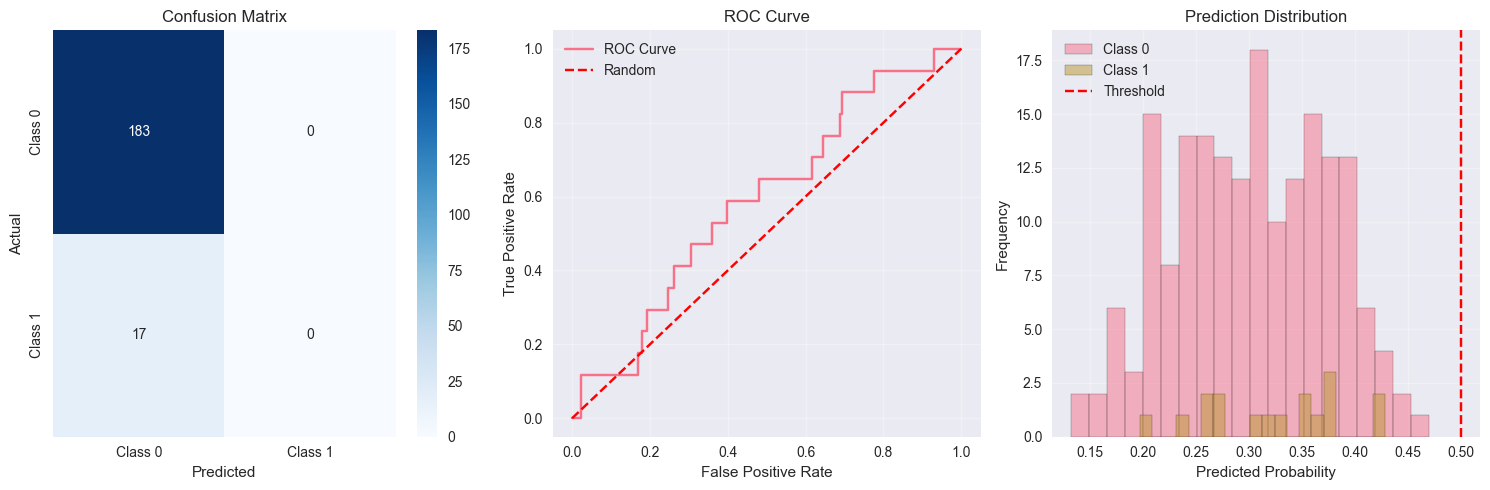

In [18]:
# Visualization: Predictions vs Actual
if is_binary:
    # Binary classification visualizations
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    val_pred_binary = (val_predictions > 0.5).astype(int)
    cm = confusion_matrix(val_labels, val_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    
    plt.subplot(1, 3, 2)
    from sklearn.metrics import roc_curve
    try:
        fpr, tpr, _ = roc_curve(val_labels, val_predictions)
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.plot([0, 1], [0, 1], 'r--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
    except:
        plt.text(0.5, 0.5, 'ROC Curve\n(Need both classes)', 
                ha='center', va='center')
        plt.title('ROC Curve')
    
    plt.subplot(1, 3, 3)
    plt.hist(val_predictions[val_labels == 0], bins=20, alpha=0.5, 
            label='Class 0', edgecolor='black')
    plt.hist(val_predictions[val_labels == 1], bins=20, alpha=0.5, 
            label='Class 1', edgecolor='black')
    plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    # Regression visualizations
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(val_labels, val_predictions, alpha=0.5)
    plt.plot([val_labels.min(), val_labels.max()], 
             [val_labels.min(), val_labels.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs Actual Values')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    residuals = val_labels - val_predictions
    plt.scatter(val_predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## 11. Make Predictions on New Data


In [19]:
# Example: Make predictions on a few samples
model.eval()
with torch.no_grad():
    # Get a batch
    features, labels = next(iter(val_loader))
    features = features.to(device)
    
    # Make predictions
    predictions = model(features)
    
    # For binary classification, apply sigmoid
    if is_binary:
        predictions = torch.sigmoid(predictions)
        pred_classes = (predictions > 0.5).float()
    
    # Display results
    print("Sample Predictions:")
    print("="*60)
    for i in range(min(10, len(predictions))):
        print(f"Sample {i+1}:")
        print(f"  Features: {features[i].cpu().numpy()}")
        if is_binary:
            print(f"  Predicted Probability: {predictions[i].item():.4f}")
            print(f"  Predicted Class: {pred_classes[i].item():.0f}")
            print(f"  Actual: {labels[i].item():.0f}")
            print(f"  Correct: {pred_classes[i].item() == labels[i].item()}")
        else:
            print(f"  Predicted: {predictions[i].item():.4f}")
            print(f"  Actual: {labels[i].item():.4f}")
            print(f"  Error: {abs(predictions[i].item() - labels[i].item()):.4f}")
        print()


Sample Predictions:
Sample 1:
  Features: [  0 176   0   5   9]
  Predicted Probability: 0.3194
  Predicted Class: 0
  Actual: 0
  Correct: True

Sample 2:
  Features: [0 0 1 1 3]
  Predicted Probability: 0.2522
  Predicted Class: 0
  Actual: 0
  Correct: True

Sample 3:
  Features: [  0 287  11   5   3]
  Predicted Probability: 0.3895
  Predicted Class: 0
  Actual: 0
  Correct: True

Sample 4:
  Features: [  0 171   6   4   1]
  Predicted Probability: 0.3016
  Predicted Class: 0
  Actual: 0
  Correct: True

Sample 5:
  Features: [  0 324  10   0   2]
  Predicted Probability: 0.3166
  Predicted Class: 0
  Actual: 0
  Correct: True

Sample 6:
  Features: [0 0 5 0 2]
  Predicted Probability: 0.2041
  Predicted Class: 0
  Actual: 0
  Correct: True

Sample 7:
  Features: [ 0 35  0  3  7]
  Predicted Probability: 0.2070
  Predicted Class: 0
  Actual: 0
  Correct: True

Sample 8:
  Features: [ 0  0  9  4 12]
  Predicted Probability: 0.3082
  Predicted Class: 0
  Actual: 1
  Correct: False

S

## 12. Save Model


In [21]:
# Save the trained model
import pickle

model_save_path = 'convfm_trained_model.pth'
preprocessor_save_path = 'convfm_preprocessor.pkl'

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'field_dims': field_dims,
    'config': {
        'embed_dim': config.embed_dim,
        'num_filters': config.num_filters,
        'filter_sizes': config.filter_sizes,
        'dropout': config.dropout,
        'use_bn': config.use_bn,
    },
    'val_loss': best_val_loss,
}, model_save_path)

# Save preprocessor
with open(preprocessor_save_path, 'wb') as f:
    pickle.dump(preprocessor, f)

print(f"Model saved to: {model_save_path}")
print(f"Preprocessor saved to: {preprocessor_save_path}")


Model saved to: convfm_trained_model.pth
Preprocessor saved to: convfm_preprocessor.pkl


## 13. Load Saved Model (Optional)


In [22]:
# Example: Load a saved model
# Uncomment to use:
# checkpoint = torch.load(model_save_path, map_location=device)
# 
# loaded_model = ConvFM(
#     field_dims=checkpoint['field_dims'],
#     embed_dim=checkpoint['config']['embed_dim'],
#     num_filters=checkpoint['config']['num_filters'],
#     filter_sizes=checkpoint['config']['filter_sizes'],
#     dropout=checkpoint['config']['dropout'],
#     use_bn=checkpoint['config']['use_bn']
# ).to(device)
# 
# loaded_model.load_state_dict(checkpoint['model_state_dict'])
# loaded_model.eval()
# 
# print("Model loaded successfully!")
